# Tutorial 1: Salmonella dataset

## Background

This tutorial consists of an index constructed from a *Salmonella enterica* dataset previously published in (https://doi.org/10.1128/jcm.02200-15). To prepare the data, the genomes were downloaded, downsampled (to min 30x coverage) to reduce data size and run through [snippy](https://github.com/tseemann/snippy) to identify SNVs. These files were then loaded into a genomics index using the `gdi load snippy` command.

## Getting data

Let's first download the data for this tutorial. To do this please run the below commands:

*Note: In a Jupyter Python notebook, prepending a command with `!` runs the command in a shell instead of the Python interpreter (e.g., `!unzip` runs the command `unzip`).*

In [1]:
#! wget ...
!unzip -n salmonella-project.zip
!ls

Archive:  salmonella-project.zip
out.aln		    salmonella-project.zip	   tutorial-1-salmonella.ipynb
salmonella-project  salmonella-project.zip.sha256


Great. Now that we've got some data (in the `salmonella-project/` directory), let's explore the command-line interface to access this data.

## Command-line interface (`gdi`)

### List samples

The below command lists the samples loaded in this index. Note that instead of passing the project with `--project-dir` you can change to the project directory and `gdi` will figure out which project you're in.

In [2]:
!gdi --project-dir salmonella-project list samples | head -n 5

SH09-29
SH10-015
SH12-001
SH13-001
SH14-003


### List reference genomes

This lists all the loaded reference genomes in this genomics index. This can be useful for commands later which require you to pass the name of the reference genome.

In [3]:
!gdi --project-dir salmonella-project list genomes

S_HeidelbergSL476


### Query for a particular mutation

This searches for a particular mutation (in this case a deletion of a `CG` at position 2865334 and an insertion of a `G`). If you are familiar with the VCF format, this is given in terms of `CHROM:POS:REF:ALT` format.

In [4]:
!gdi --project-dir salmonella-project query mutation 'gi|194447306|ref|NC_011083.1|:2865334:CG:C' | column -s$'\t' -t

Type      Feature                                     Sample Name  Sample ID  Status
mutation  gi|194447306|ref|NC_011083.1|:2865334:CG:C  SH12-013     9          Present


## Build an alignment

To build an alignment for use in further phylogenetics software you can do the following.

In [5]:
!gdi --project-dir salmonella-project build alignment --reference-name S_HeidelbergSL476 --align-type full --output-file out.aln

Wrote alignment to [out.aln]


In [6]:
!head -n 2 out.aln

>SH08-001 generated automatically
AGAGANTACGTNTGGTTGCAAGAGATCATAACAGGGGGAATTAGTTGAAAATAAATATAT


This will produce an alignment with length equal to the reference genome, masking any missing data or gaps with `N`, and concatenating individual sequences (contigs) in the alignment together to construct a single, whole-genome alignment.

You can pass in specific samples to include with `--sample`.

# Python API (Genomics Data Index API)

Now let's move on to the Python interface for loading, and querying data in this index. This is a much more powerful (and flexible) way to work with your data which attempts to provide seamless data flow between this index and Python [pandas](https://pandas.pydata.org/).

We first start out by connecting to our project through `GenomicsDataIndex`.

In [7]:
import genomics_data_index.api as gdi

db = gdi.GenomicsDataIndex.connect('salmonella-project')
db

<GenomicsDataIndex(samples=59)>

Great. We're connected. The `samples=59` tells us how many samples are in this database.

You can run `db.sample_names()` or `db.reference_names()` to list the samples and reference genomes in this database.

In [8]:
db.sample_names()[0:5]

['SH09-29', 'SH10-015', 'SH12-001', 'SH13-001', 'SH14-003']

In [9]:
db.reference_names()

['S_HeidelbergSL476']

## List all features (mutations)

To list a summary of all indexed mutations we can do:

In [10]:
db.mutations_summary(reference_genome='S_HeidelbergSL476')

,Sequence,Position,Deletion,Insertion,Count
Mutation,,,,,
gi|194447306|ref|NC_011083.1|:34780:A:G,gi|194447306|ref|NC_011083.1|,34780,A,G,3
gi|194447306|ref|NC_011083.1|:43651:G:T,gi|194447306|ref|NC_011083.1|,43651,G,T,1
gi|194447306|ref|NC_011083.1|:58804:T:A,gi|194447306|ref|NC_011083.1|,58804,T,A,10
gi|194447306|ref|NC_011083.1|:63393:C:A,gi|194447306|ref|NC_011083.1|,63393,C,A,13
gi|194447306|ref|NC_011083.1|:70519:T:TG,gi|194447306|ref|NC_011083.1|,70519,T,TG,6
...,...,...,...,...,...
gi|194447306|ref|NC_011083.1|:4860641:G:A,gi|194447306|ref|NC_011083.1|,4860641,G,A,57
gi|194447306|ref|NC_011083.1|:4876176:A:G,gi|194447306|ref|NC_011083.1|,4876176,A,G,58
gi|194447306|ref|NC_011083.1|:4882099:C:T,gi|194447306|ref|NC_011083.1|,4882099,C,T,57


This gives us back a DataFrame summarizing the mutations.


## Search for a particular mutation (`hasa()`)

We can search for genomic samples containing particular mutation by starting a query and using the `hasa()` method.

In [12]:
q = db.samples_query().hasa('gi|194447306|ref|NC_011083.1|:63393:C:A', kind='mutation')
q

<SamplesQueryIndex[22% (13/59) samples]>

The `hasa()` method can be read as "select samples that **have a** this particular mutation". The selected samples is printed above (13/59 have this particular mutation).

*Note: the default **kind** for `hasa()` is `mutation` so you can leave out `kind='mutation'` if you wish.*

In [13]:
q = db.samples_query().hasa('gi|194447306|ref|NC_011083.1|:63393:C:A')
q

<SamplesQueryIndex[22% (13/59) samples]>

Once we have a query/selection of samples the specific samples can be shown with the `toframe()` method:

In [15]:
q.toframe()

,Query,Sample Name,Sample ID,Status
0,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-001,3,Present
1,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-003,13,Present
2,gi|194447306|ref|NC_011083.1|:63393:C:A,SH11-001,15,Present
3,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-002,18,Present
4,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-004,24,Present
5,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-008,37,Present
6,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-011,38,Present
7,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-005,40,Present
8,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-010,41,Present
9,gi|194447306|ref|NC_011083.1|:63393:C:A,SH12-006,45,Present


Or you can use `summary()`

In [16]:
q.summary()

,Query,Present,Absent,Unknown,Total,% Present,% Absent,% Unknown
0,gi|194447306|ref|NC_011083.1|:63393:C:A,13,46,<NA>,59,22.033898,77.966102,<NA>


Or you can use `tolist()`

In [17]:
q.tolist()

['SH12-001',
 'SH12-003',
 'SH11-001',
 'SH12-002',
 'SH12-004',
 'SH12-008',
 'SH12-011',
 'SH12-005',
 'SH12-010',
 'SH12-006',
 'SH12-009',
 'SH12-007',
 'SH10-001']

## Chaining queries

Queries can be chained together to select samples that match every criteria given in the `has()` method.

In [18]:
q = db.samples_query() \
    .hasa('gi|194447306|ref|NC_011083.1|:63393:C:A') \
    .hasa('gi|194447306|ref|NC_011083.1|:4876176:A:G')
q

<SamplesQueryIndex[22% (13/59) samples]>

This can be read as "select all samples that **have a** 63393 C to A mutation **AND** select all samples that **have a** 4876176 A to G mutation".

## Searching for a particular sample (`isa()` and `isin()`)

The `isa()` and `isin()` methods let us search for particular samples by name. The difference between the two is that:

1. `isa()` is meant to be read "select samples that **are** (**is a**) type matching the expression.
2. `isin()` is meant to be read "select samples that are **in** a set defined by the passed criteria.

The differences between these become more apparent for more advanced queries later on. For now, we can use these to select samples by name.

In [20]:
q = db.samples_query().isa('SH12-001')
q

<SamplesQueryIndex[2% (1/59) samples]>

In [21]:
q = db.samples_query().isin(['SH12-001', 'SH13-001'])
q

<SamplesQueryIndex[3% (2/59) samples]>

## Searching within a tree

Queries are not limited to what mutations a sample has or by sample name. We can also use `isin()` to select samples that match criteria related to a phylogenetic tree.

To do this, we must specify that our query has a tree attached to it. The example data for this tutorial does have such a tree (though it can be built on-the-fly if needed using `build_tree()`).

In [22]:
t = db.samples_query(universe='mutations', reference_name='S_HeidelbergSL476')
t

<TreeSamplesQuery[100% (59/59) samples]>

Here, the type of query is a `TreeSampleQuery` which means it has a tree attached to it. You can access the underlying tree with the `tree` property (as an ete3 Tree object).

In [23]:
t.tree

Tree node '' (0x7f23fec5661)

You can quickly visualize the tree in-line by using the `tree_styler()` method:

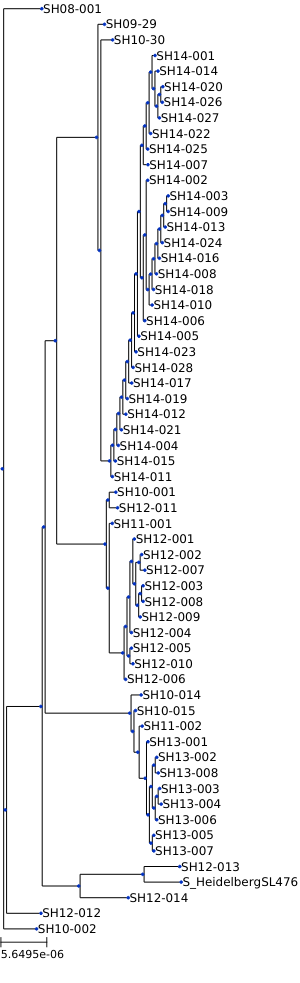

In [39]:
t.tree_styler().render(w=300)

Now that we have a phylogenetic tree, we can search using this tree with `isin()`. To do this, let's search for samples within some distance from `SH14-001`.

In [56]:
tdist = t.isin('SH14-001', kind='distance', distance=3e-7, units='substitutions/site')
tdist

<TreeSamplesQuery[8% (5/59) samples]>

This selects a subset of samples within the above distance (given in `'substitutions/site'`, you can also use `units='substitutions'`).

It can be hard to see what is going on, so we can combine our query with the tree visualization using the `highlight()` method to highlight the selected samples in the tree.

*Note: I still have to confirm this, but I suspect some samples (e.g., `SH14-014`) are not selected even though it looks like it should be is due to the way the tree is drawn by ete3.*

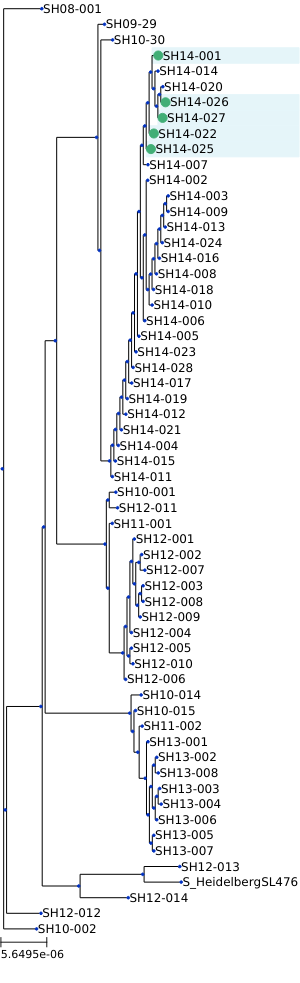

In [57]:
t.tree_styler().highlight(tdist).render(w=300)

Another type of query instead of distance is `mrca` which selects samples that all share a particular most recent common ancestor.

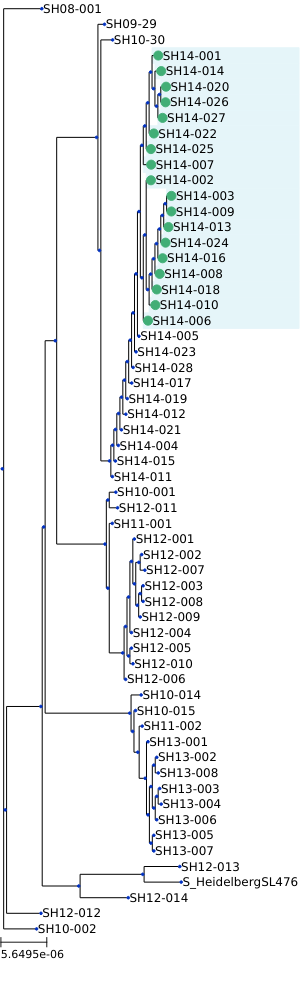

In [58]:
tmrca = t.isin(['SH14-001', 'SH14-002'], kind='mrca')
t.tree_styler().highlight(tmrca).render(w=300)

## Attach external metadata

So far we've been looking at only the genomics data. But often times many details insights can be derived from the associated metadata with the genomic samples. External metadata can be attached and tracked by our queries. This also gives us annother method for selecting samples using pandas selection statements (e.g., `metadata['Column'] == 'value'`).

To attach external metadata we first must load it up in Python as a DataFrame (note `head(3)` just means only print the first 3 rows, which avoids printing a very large table for this tutorial).

In [59]:
import pandas as pd

metadata_df = pd.read_csv('salmonella-project/metadata.tsv', sep='\t', dtype=str)
metadata_df.head(3)

,Strain,Source,Isolation date,Outbreak number,PFGE pattern,PT,Canadian PFGE pattern
0,SH12-001,Human,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
1,SH12-002,Human,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
2,SH12-003,Human,05-2012,1,2,19,SHXAI.0001/SHBNI.0001


Now we can attach to our query using the `join()` method:

In [68]:
# Setup a new query (you don't have to do this, but this makes sure the results are all as expected in the tutorial)
q = db.samples_query().hasa('gi|194447306|ref|NC_011083.1|:4860641:G:A')

# Join our query with the given data frame
q = q.join(metadata_df, sample_names_column='Strain')
q

<DataFrameSamplesQuery[97% (57/59) samples]>

To join we had to define a column containing the sample names. We now get back a query of type `DataFrameSamplesQuery`.

## Query external metadata

We can continue using this to select samples and when we're done use the `toframe()` method to dump out our selected data as a DataFrame.

In [62]:
q.hasa('gi|194447306|ref|NC_011083.1|:70519:T:TG').toframe()

,Query,Sample Name,Sample ID,Status,Strain,Source,Isolation date,Outbreak number,PFGE pattern,PT,Canadian PFGE pattern
0,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH13-001,4,Present,SH13-001,Human,11-2013,2,2,26,SHXAI.0001/SHBNI.0001
1,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH13-003,32,Present,SH13-003,Human,11-2013,2,2,26,SHXAI.0001/SHBNI.0001
2,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH13-004,25,Present,SH13-004,Human,11-2013,2,2,26,SHXAI.0001/SHBNI.0001
3,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH13-005,47,Present,SH13-005,Human,11-2013,2,2,26,SHXAI.0001/SHBNI.0001
4,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH13-006,54,Present,SH13-006,Human,11-2013,2,2,26,SHXAI.0001/SHBNI.0001
5,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH13-007,16,Present,SH13-007,Human,11-2013,2,2,26,SHXAI.0001/SHBNI.0001


Running `toframe()` will add some additional columns to the front of the external data frame defining the genomics query information.

## Selecting by column values using `isa()`

We can now use the `isa()` method to select samples by values in a particular metadata column. For example, to select all samples with a **Source** of `Food` we can use:

In [69]:
q.isa('Food', isa_column='Source', kind='dataframe').toframe().head(3)

,Query,Sample Name,Sample ID,Status,Strain,Source,Isolation date,Outbreak number,PFGE pattern,PT,Canadian PFGE pattern
0,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH12-009,50,Present,SH12-009,Food,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
1,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH12-010,41,Present,SH12-010,Food,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
2,gi|194447306|ref|NC_011083.1|:4860641:G:A AND ...,SH14-013,42,Present,SH14-013,Food,08-2014,3,2,19,SHXAI.0001/SHBNI.0001


To make it easier to write these query expressions, you can set a default column for `isa()` queries when joining to a dataframe:

In [74]:
q = db.samples_query().join(metadata_df, sample_names_column='Strain',
                            default_isa_kind='dataframe', default_isa_column='Source')
q.isa('Food').toframe().head(3)

,Query,Sample Name,Sample ID,Status,Strain,Source,Isolation date,Outbreak number,PFGE pattern,PT,Canadian PFGE pattern
0,dataframe(names_col=[Strain]) AND isa('Source'...,SH12-009,50,Present,SH12-009,Food,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
1,dataframe(names_col=[Strain]) AND isa('Source'...,SH12-010,41,Present,SH12-010,Food,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
2,dataframe(names_col=[Strain]) AND isa('Source'...,SH14-013,42,Present,SH14-013,Food,08-2014,3,2,19,SHXAI.0001/SHBNI.0001


You can also pass `regex=True` to `isa()` to query by a regex.

## Selecting by pandas selection expressions

You can also select samples using the more powerful pandas selection expressions. You use the `isin()` method for this.

For example, an alternative way to select samples where **Source** is `Food` is:

In [75]:
q.isin(metadata_df['Source'] == 'Food', kind='dataframe').toframe().head(3)

,Query,Sample Name,Sample ID,Status,Strain,Source,Isolation date,Outbreak number,PFGE pattern,PT,Canadian PFGE pattern
0,dataframe(names_col=[Strain]) AND isin(subset ...,SH12-009,50,Present,SH12-009,Food,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
1,dataframe(names_col=[Strain]) AND isin(subset ...,SH12-010,41,Present,SH12-010,Food,05-2012,1,2,19,SHXAI.0001/SHBNI.0001
2,dataframe(names_col=[Strain]) AND isin(subset ...,SH14-013,42,Present,SH14-013,Food,08-2014,3,2,19,SHXAI.0001/SHBNI.0001


# Putting it all together

So far we've seen connecting to an index (project), querying by mutations and by relationships in a tree, as well as attaching external metadata. We can put this all together and do some basic visualiations of our selections on the tree (using the `ete3` toolkit).

## 1. Highlight everything in Outbreak 1 with a particular mutation

In [76]:
# Load up a tree query object and attach a Data Frame
q = db.samples_query(universe='mutations', reference_name='S_HeidelbergSL476')\
    .join(metadata_df, sample_names_column='Strain')
q

<TreeSamplesQuery[100% (59/59) samples]>

In [78]:
# Select samples in Outbreak 1 and show all possible mutations
q.isa('1', isa_column='Outbreak number', kind='dataframe')

Exception: Invalid kind=dataframe. Must be one of ['names']

In [77]:
# Use `highlight()` to highlight Outbreak 1 and chain with another `highlight()` to highlight '' mutation in a different color
ts = q.tree_styler()\
        .highlight()\
        .highlight()
ts.render()

In [ ]:
# Save this to a PDF file
ts.render('output1.pdf')